In [1]:
import torch as th
from sb3_contrib import TQC
from active_critic.utils.gym_utils import make_policy_dict
from stable_baselines3.common.torch_layers import CombinedExtractor
from stable_baselines3.common.evaluation import evaluate_policy
import gym
import numpy as np
from gym import Env
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
import numpy as np
import torch as th
from metaworld.envs import \
    ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
from metaworld.policies import *
from gym.wrappers import TimeLimit
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from active_critic.utils.rollout import rollout, make_sample_until, flatten_trajectories
from stable_baselines3.common.type_aliases import GymEnv
from gym import Env
import gym
from stable_baselines3.common.evaluation import evaluate_policy
from active_critic.utils.gym_utils import sample_expert_transitions, parse_sampled_transitions, new_epoch_reach, DummyExtractor
from active_critic.utils.tboard_graphs import TBoardGraphs


class ResetCounterWrapper(gym.Wrapper):
    def __init__(self, env: Env) -> None:
        super().__init__(env)
        self.reset_count = 0

    def reset(self):
        self.reset_count+=1
        return super().reset()

    def step(self, action):
        
        obsv, rew, done, info = super().step(action)
        if info['success']:
            done = True
        return obsv, rew, done, info

class ImitationLearningWrapper:
    def __init__(self, policy, env: GymEnv):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.policy = policy

    def predict(self, obsv, deterministic=None):
        actions = []
        for obs in obsv:
            actions.append(self.policy.get_action(obs))
        return actions

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2022-10-16 22:48:34.283921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def make_dummy_vec_env(name, seq_len):
    policy_dict = make_policy_dict()

    env_tag = name
    max_episode_steps = seq_len
    env = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]]()
    env._freeze_rand_vec = False
    reset_env = ResetCounterWrapper(env=env)
    timelimit = TimeLimit(env=reset_env, max_episode_steps=max_episode_steps)
    dv1 = DummyVecEnv([lambda: RolloutInfoWrapper(timelimit)])
    vec_expert = ImitationLearningWrapper(
        policy=policy_dict[env_tag][0], env=dv1)
    return dv1, vec_expert


In [6]:
def evaluate_policy(policy, env, episodes, device, path, logname, step):
    transitions = sample_expert_transitions(
        policy, env, episodes)
    actions, observations, rewards = parse_sampled_transitions(
        transitions=transitions, new_epoch=new_epoch_reach, extractor=DummyExtractor(), device=device)
    rewards = rewards.unsqueeze(-1)
    last_reward, _ = rewards.max(dim=1)
    success = (last_reward == 1)
    success = success.type(th.float)
    tboard = TBoardGraphs(logname, data_path=path)

    tboard.plotDMPTrajectory(actions[0], actions[0], th.zeros_like(actions[0]),
                                      None, None, None, stepid=step, save=False, name_plot='Trajectory', path=None,
                                      tol_neg=None, tol_pos=None, inpt=None, name='Trajectory', opt_gen_trj=None, window=None)
    tboard.plotDMPTrajectory(rewards[0], rewards[0], th.zeros_like(rewards[0]),
                                      None, None, None, stepid=step, save=False, name_plot='Rewards', path=None,
                                      tol_neg=None, tol_pos=None, inpt=None, name='Rewards', opt_gen_trj=None, window=None)
    tboard.addTrainScalar('rewards', value=last_reward.mean().to('cpu'), stepid=step)      
    tboard.addTrainScalar('success', value=success.mean().to('cpu'), stepid=step)      

In [7]:
seq_env, expert = make_dummy_vec_env(name='reach', seq_len=100)
seq_env_eval, expert = make_dummy_vec_env(name='reach', seq_len=100)

policy_kwargs = dict(net_arch=[64, 64], n_critics=1)
tqc_learner = TQC(policy='MlpPolicy',learning_rate=0.001, env=seq_env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)
path = '/home/hendrik/Documents/master_project/LokalData/baselines'

Using cuda device


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sampling transitions. 100


2022-10-16 22:50:10.150172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sampling transitions. 100
Sampling transitions. 100


KeyboardInterrupt: 

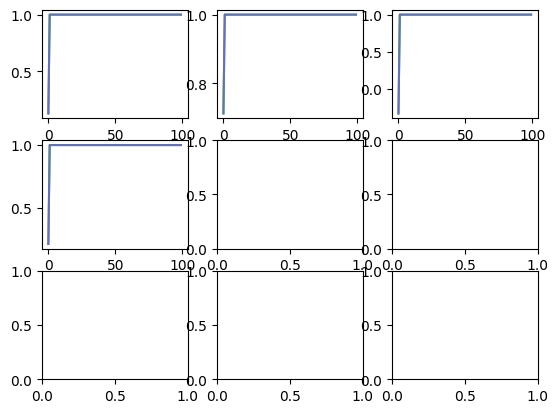

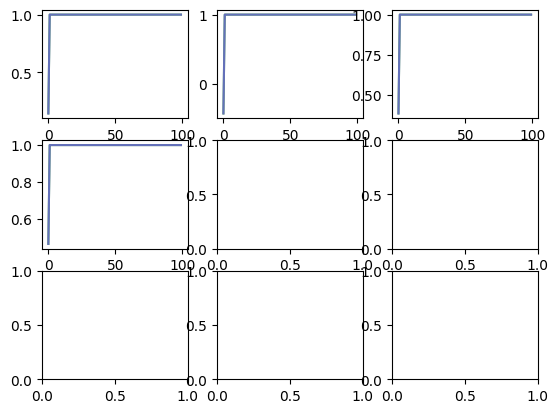

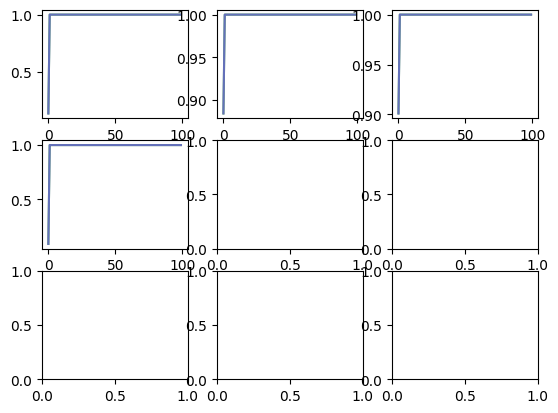

In [8]:
for i in range(100):
    tqc_learner.learn(2000, log_interval=float('inf'))
    evaluate_policy(policy=tqc_learner.policy, env=seq_env_eval, episodes=100, device='cuda', path=path, logname='tqc_reach_success_stop', step=seq_env.envs[0].reset_count)


In [ ]:
d

[array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [ ]:
e = np.array(d)

In [ ]:
e

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [ ]:
seq_env.envs[0].reset_count

In [ ]:
import torch as th

In [ ]:
obsv = seq_env.reset()
rews = []
success = []
actions = []
for i in range(10000):
    action = tqc_learner.policy.predict(obsv[0])
    actions.append(action[0])
    obsv, rew, done, info = seq_env.step(action)
    rews.append(rew)
    if done[0]:
        success.append(info[0]['success'])

In [ ]:
actions = np.array(actions)
actions.shape

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(rews)), actions[:,3])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(rews)), np.array(rews))

In [ ]:
success